# InfoGAN

In [1]:
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras import optimizers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

In [2]:
class InfoGAN:
  def __init__(self,num_latent=100, image_shape=(28,28,1)):
    num_labels = 10
    self.image_shape = image_shape
    self.num_latent = num_latent
    self.num_labels = num_labels
    self.inputs = layers.Input(shape=(num_latent,))
    self.labels = layers.Input(shape=(num_labels,))
    self.code1 = layers.Input(shape=(1,))
    self.code2 = layers.Input(shape=(1,))
    self.generator = self.build_generator(self.inputs, labels=self.labels, 
                                          codes=[self.code1, self.code2])
    inputs = layers.Input(shape=image_shape)
    self.discriminator = self.build_discriminator(inputs, num_labels=num_labels, num_codes=2)
  
  @staticmethod
  def build_generator(inputs, image_shape=(28,28,1), labels=None, codes=None):
    img_resize = image_shape[0]//4
    kernel_size = 5
    kernels = [128, 64, 32, 1]
    if labels is not None:
      if codes is None:
        inputs = [inputs, labels]
      else:
        inputs = [inputs, labels] + codes
      x = layers.Concatenate()(inputs)
    elif codes is not None:
      inputs = [inputs] + codes
      x = layers.Concatenate()(inputs)
    else:
      x = inputs
    
    x = layers.Dense(img_resize * img_resize * kernels[0])(x)
    x = layers.Reshape((img_resize , img_resize , kernels[0]))(x)
    for kernel in kernels:
      if kernel>=kernels[1]:
        strides = 2
      else:
        strides = 1
      x = layers.BatchNormalization()(x)
      x = layers.Activation('relu')(x)
      x = layers.Conv2DTranspose(kernel, kernel_size, strides=strides, padding='same')(x)
    
    x = layers.Activation('sigmoid')(x)
    return keras.Model(inputs, x, name = 'Generator')

  @staticmethod
  def build_discriminator(inputs, num_labels=None, num_codes=None):
    kernel_size = 5
    kernels = [128, 64, 32, 1]
    x = inputs 
    for kernel in kernels:
      if kernel > kernels[-1]:
        strides = 2
      else:
        strides = 1
      x = layers.LeakyReLU()(x)
      x = layers.Conv2D(kernel, kernel_size, strides=strides, padding='same')(x)
    
    x = layers.Flatten()(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    if num_labels:
      x2 = layers.Dense(kernels[-2])(x)
      labels = layers.Dense(num_labels, activation='softmax', name='label')(x2)
      if num_codes is None:
        outputs = [outputs, labels]
      else:
        code1 = layers.Dense(1, activation='sigmoid', name='code1')(x2)
        code2 = layers.Dense(1, activation='sigmoid', name='code2')(x2)
        outputs = [outputs, labels, code1, code2]
    elif num_codes:
      z0 = layers.Dense(num_codes, activation='tanh', name='codes')(x)
      outputs = [outputs, z0]

    return keras.Model(inputs, outputs, name='Discriminator')
  
  @staticmethod
  def mi_loss(c, q_of_c_given_x):
    # mi_loss = -c * log(Q(c|x))
    return K.mean(-K.sum(K.log(q_of_c_given_x + K.epsilon())*c, axis=1))

  def compile(self):
    lr = 1e-4
    decay = 7e-8
    optimizer = optimizers.Adam(lr, decay=decay)
    loss = ['binary_crossentropy', 'categorical_crossentropy', self.mi_loss, self.mi_loss]
    self.discriminator.compile(loss=loss, optimizer=optimizer, metrics=['acc'])
    optimizer = optimizers.Adam(lr*0.5, decay=decay*0.5)
    inputs = [self.inputs, self.labels, self.code1, self.code2]
    self.discriminator.trainable = False
    self.adversarial = keras.Model(inputs, self.discriminator(self.generator(inputs)), name='adversarial')
    loss_weights = [1.0, 1.0, 0.8, 0.8]
    self.adversarial.compile(loss=loss, optimizer=optimizer, metrics = ['acc'], loss_weights=loss_weights)
    #self.adversarial.compile(loss=loss, optimizer=optimizer, metrics = ['acc'])

  def fit(self, data, batch_size, epochs):
    X, Y = data
    X, Y = data
    X_size = X.shape[0]
    steps = X_size//batch_size
    for e in range(epochs):
      accLD, accLA = 0, 0
      lossA, lossD = 0, 0
      for i in range(steps):
        rand_idx = np.random.randint(0, X_size, size=batch_size)
        real_imgs = X[rand_idx]
        real_labels = Y[rand_idx]
        real_code1 = np.random.normal(scale=0.5, size=[batch_size, 1])
        real_code2 = np.random.normal(scale=0.5, size=[batch_size, 1])
        # Generamos las imagenes falsas
        noise = np.random.uniform(-1., 1., size=(batch_size, self.num_latent))
        fake_labels = np.eye(self.num_labels)[np.random.choice(self.num_labels, batch_size)]
        fake_code1 = np.random.normal(scale=0.5, size=[batch_size, 1])
        fake_code2 = np.random.normal(scale=0.5, size=[batch_size, 1])
        inputs = [noise, fake_labels, fake_code1, fake_code2]
        fake_imgs = self.generator.predict(inputs)
        # Concatenamos
        x = np.concatenate((real_imgs, fake_imgs))
        labels = np.concatenate((real_labels, fake_labels))
        codes1 = np.concatenate((real_code1, fake_code1))
        codes2 = np.concatenate((real_code2, fake_code2))
        y = np.ones([2*batch_size, 1])
        y[batch_size:, :] = 0.
        # Entrenamos el discriminador
        outputs = [y, labels, codes1, codes2]
        metrics = self.discriminator.train_on_batch(x, outputs)
        accLD += metrics[6]
        lossD += metrics[0]
        # Entrenamos el adversarial
        noise = np.random.uniform(-1., 1., size=(batch_size, self.num_latent))
        fake_labels = np.eye(self.num_labels)[np.random.choice(self.num_labels, batch_size)]
        fake_code1 = np.random.normal(scale=0.5, size=[batch_size, 1])
        fake_code2 = np.random.normal(scale=0.5, size=[batch_size, 1])
        inputs = [noise, fake_labels, fake_code1, fake_code2]
        y = np.ones([batch_size, 1])
        outputs = [y, fake_labels, fake_code1, fake_code2]
        metrics = self.adversarial.train_on_batch(inputs, outputs)
        accLA += metrics[6]
        lossA += metrics[0]
      lossD, accLD = lossD/steps, accLD/steps
      lossA, accLA = lossA/steps, accLA/steps
      print("Step {}: [D] Loss:{}, Acc:{}".format(e,lossD,accLD))
      print("Step {}: [A] Loss:{}, Acc:{}".format(e,lossA,accLA))
      self.generator.save('Generator_e{}.h5'.format(e+1))
      # Graficar imagenes
      noise = np.random.uniform(-1., 1., size=(25, self.num_latent))
      fake_labels = np.eye(self.num_labels)[np.random.choice(self.num_labels, 25)]
      fake_code1 = np.random.normal(scale=0.5, size=[25, 1])
      fake_code2 = np.random.normal(scale=0.5, size=[25, 1])
      inputs = [noise, fake_labels, fake_code1, fake_code2]
      fig, ax = plt.subplots(5,5)
      fake_imgs = self.generator.predict(inputs)
      for i in range(5):
        for j in range(5):
          ax[i,j].imshow(fake_imgs[i+5*j,:,:,0])
          print("({},{}): {}".format(i,j,fake_labels[i+5*j]))
      plt.show()

  def load_mnist(self):
    (X,Y), (_,_) = mnist.load_data()
    w,h,c = self.image_shape
    X = X.reshape((-1,w,h,c))
    self.X = X.astype('float32')/255
    self.Y = to_categorical(Y) 
    return self.X, self.Y

In [3]:
infogan = InfoGAN()

In [4]:
infogan.compile()

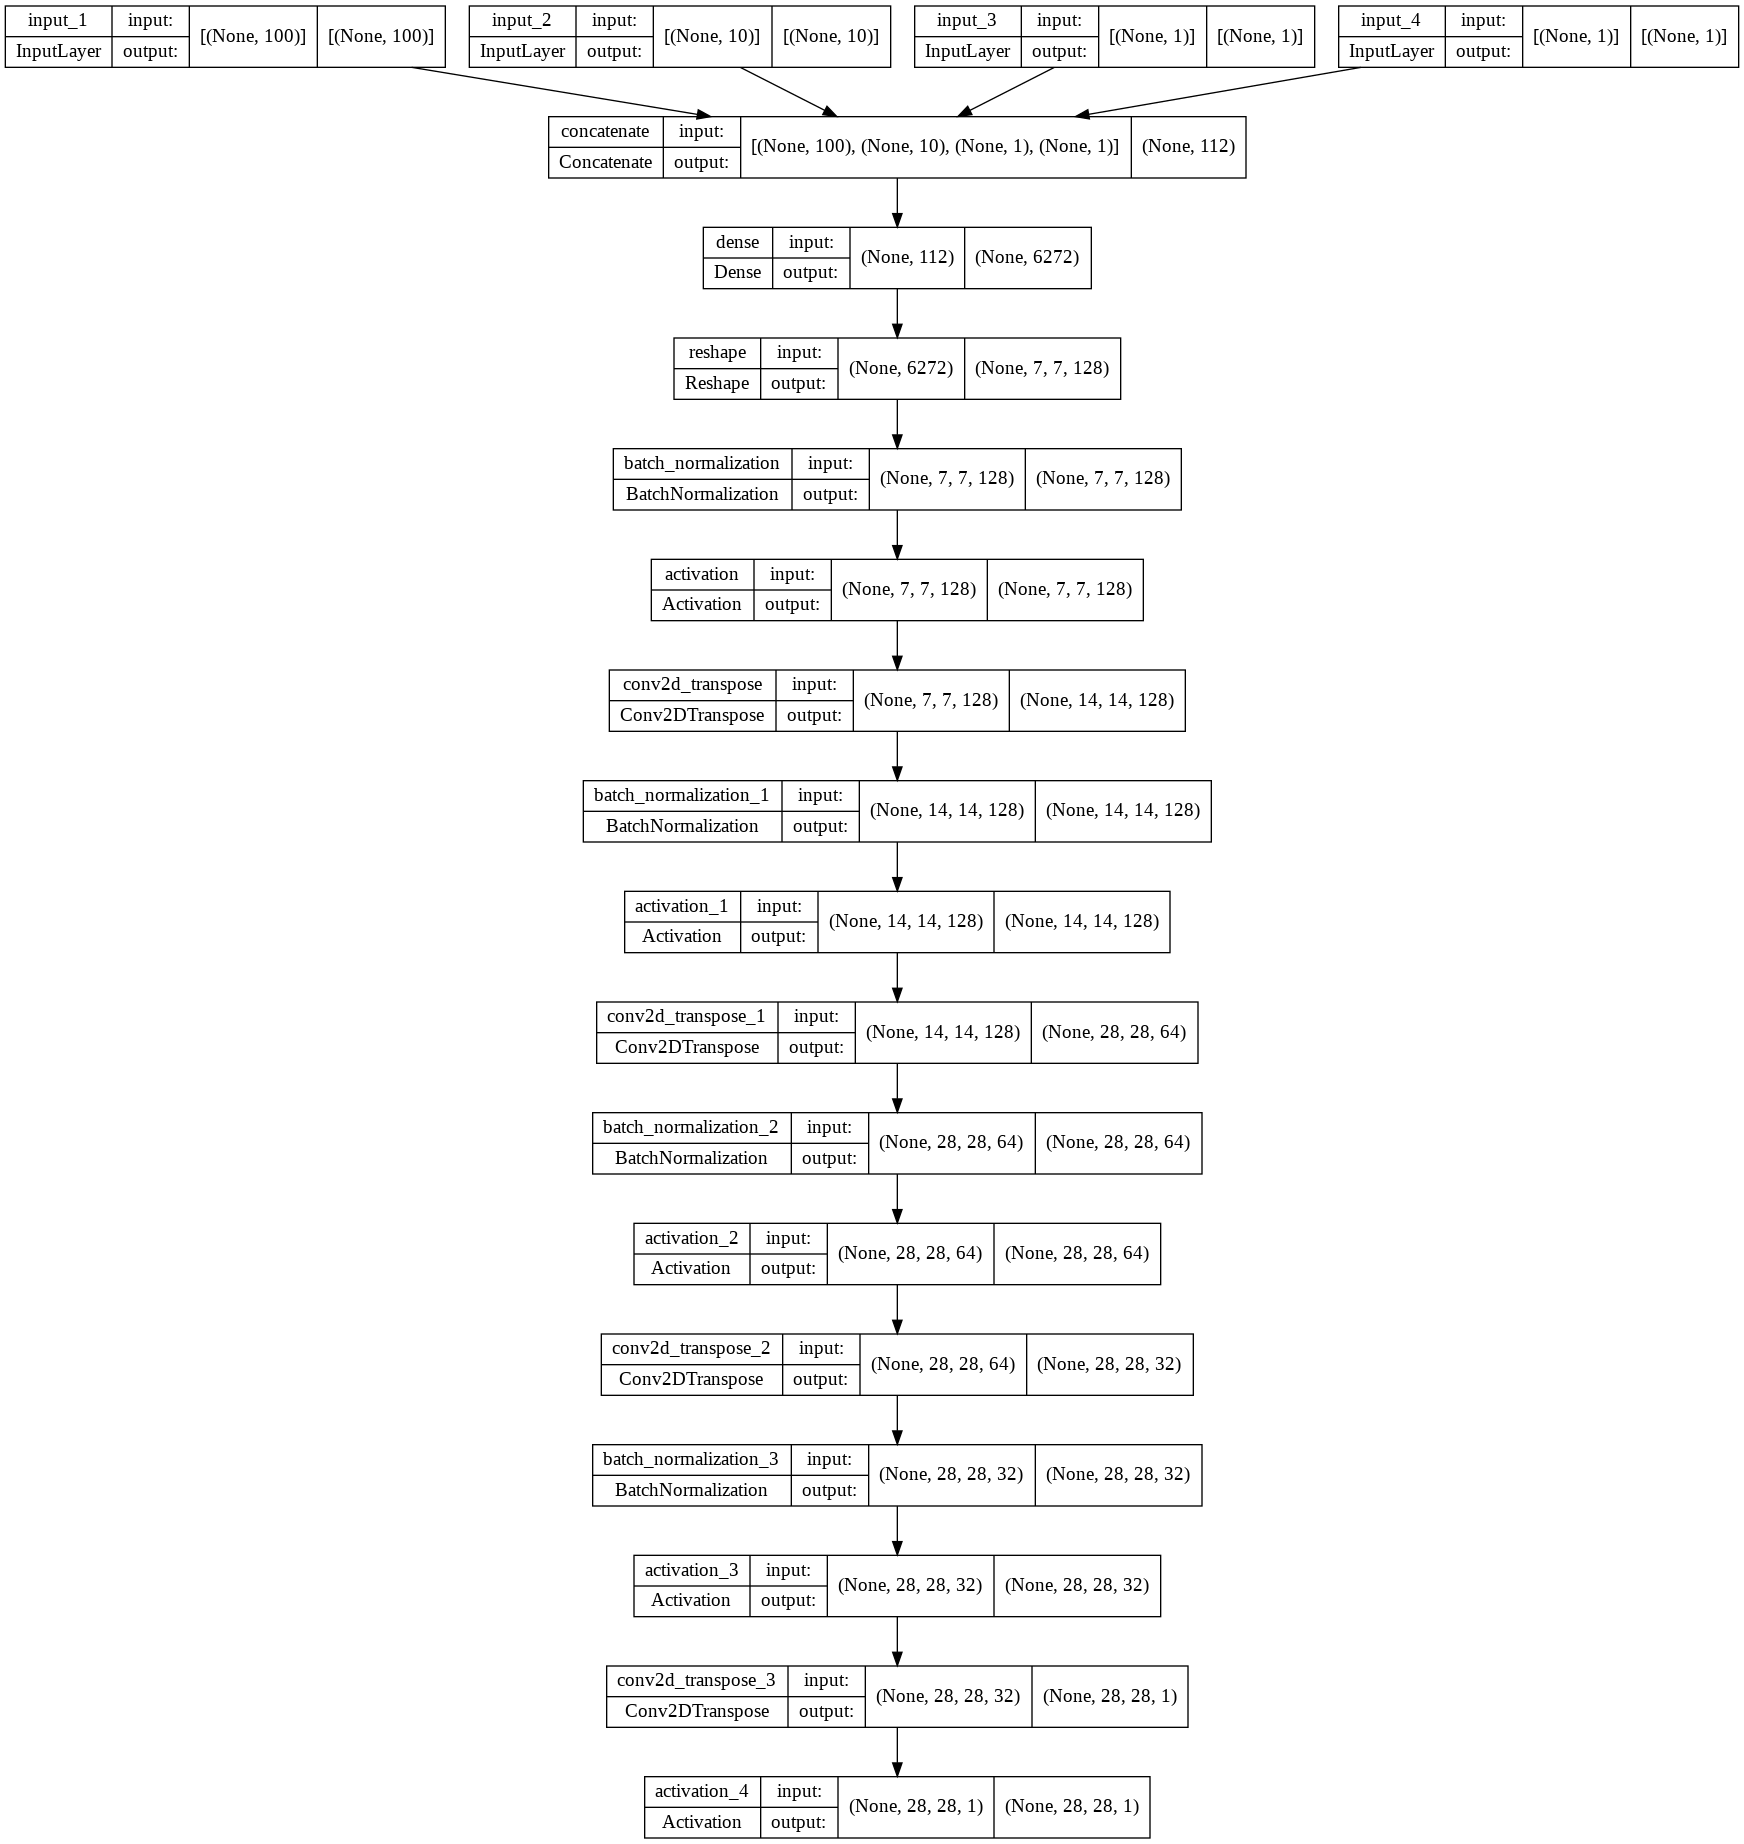

In [5]:
plot_model(infogan.generator, show_shapes=True)

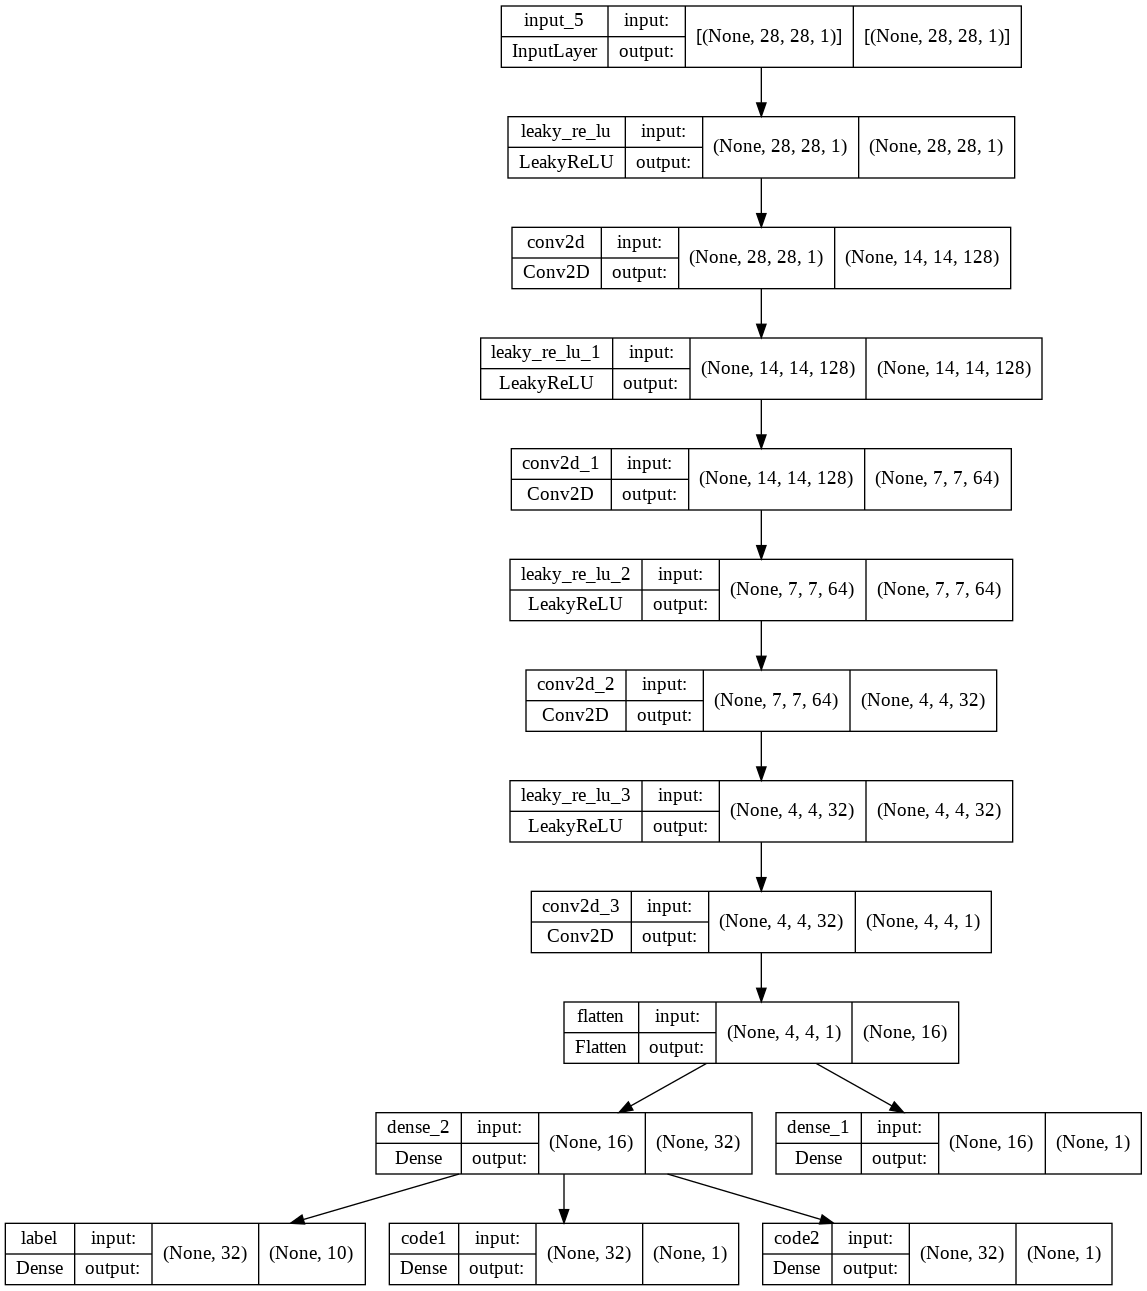

In [6]:
plot_model(infogan.discriminator, show_shapes=True)

In [7]:
X, Y = infogan.load_mnist()

11501568/11490434 [==============================] - 0s 0us/step


Step 0: [D] Loss:-0.1389782609911556, Acc:0.5994591346153846
Step 0: [A] Loss:-2.289877431642296, Acc:0.7248096955128205
(0,0): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(0,1): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(0,2): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(0,3): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(0,4): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,0): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(1,1): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(1,2): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(1,3): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(1,4): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(2,0): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(2,1): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(2,2): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(2,3): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(2,4): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,0): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(3,1): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(3,2): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(3,3): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(3,4): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(4,0): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(4,1): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(4,2): [0. 1. 0. 0. 0

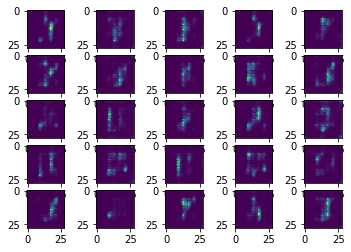

Step 1: [D] Loss:-1.577735297763959, Acc:0.8134181356837606
Step 1: [A] Loss:-4.269121294602369, Acc:0.9442441239316239
(0,0): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(0,1): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(0,2): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(0,3): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(0,4): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(1,0): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(1,1): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,2): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,3): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(1,4): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(2,0): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(2,1): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(2,2): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(2,3): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(2,4): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(3,0): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(3,1): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(3,2): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(3,3): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(3,4): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(4,0): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(4,1): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(4,2): [1. 0. 0. 0. 0.

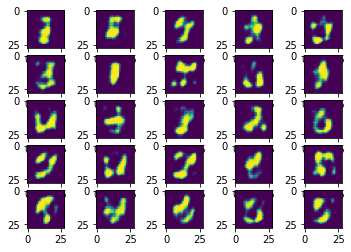

Step 2: [D] Loss:-2.100680679337591, Acc:0.8857088007478633
Step 2: [A] Loss:-3.962530160561586, Acc:0.9836905715811965
(0,0): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(0,1): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(0,2): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(0,3): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(0,4): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(1,0): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(1,1): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(1,2): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(1,3): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(1,4): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(2,0): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(2,1): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(2,2): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,3): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(2,4): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(3,0): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(3,1): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,2): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(3,3): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,4): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(4,0): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(4,1): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(4,2): [0. 0. 0. 0. 0.

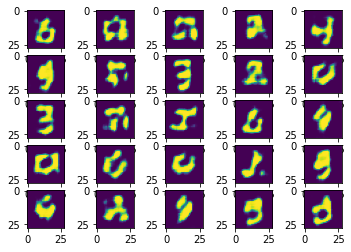

Step 3: [D] Loss:-2.293136809880917, Acc:0.9037126068376068
Step 3: [A] Loss:-4.094360953212803, Acc:0.9858774038461539
(0,0): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(0,1): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(0,2): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(0,3): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(0,4): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(1,0): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,1): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(1,2): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,3): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(1,4): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(2,0): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(2,1): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(2,2): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(2,3): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(2,4): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(3,0): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(3,1): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(3,2): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,3): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,4): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(4,0): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(4,1): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(4,2): [0. 0. 1. 0. 0.

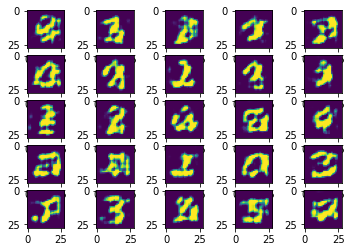

Step 4: [D] Loss:-2.212164700922803, Acc:0.9125350560897436
Step 4: [A] Loss:-4.081062199723007, Acc:0.9849926549145299
(0,0): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,1): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,2): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(0,3): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(0,4): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(1,0): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(1,1): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(1,2): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(1,3): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(1,4): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,0): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,1): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(2,2): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(2,3): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,4): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(3,0): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,1): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(3,2): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(3,3): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,4): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(4,0): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(4,1): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(4,2): [0. 0. 0. 0. 0.

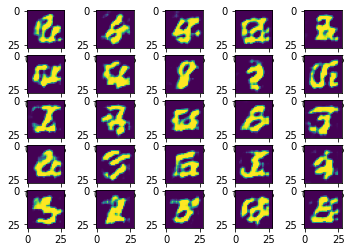

Step 5: [D] Loss:-2.2582325062945356, Acc:0.9237363114316239
Step 5: [A] Loss:-3.937540016622625, Acc:0.983573717948718
(0,0): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(0,1): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,2): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(0,3): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(0,4): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,0): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,1): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(1,2): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(1,3): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(1,4): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(2,0): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(2,1): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(2,2): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(2,3): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(2,4): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(3,0): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(3,1): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(3,2): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(3,3): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(3,4): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(4,0): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(4,1): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(4,2): [1. 0. 0. 0. 0.

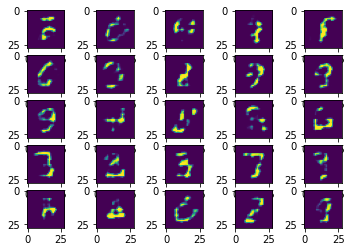

Step 6: [D] Loss:-2.2517924294767218, Acc:0.9272419204059829
Step 6: [A] Loss:-3.8417823681464562, Acc:0.9840244391025641
(0,0): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(0,1): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(0,2): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(0,3): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,4): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(1,0): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(1,1): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(1,2): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(1,3): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(1,4): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(2,0): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,1): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(2,2): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(2,3): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(2,4): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(3,0): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,1): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,2): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,3): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,4): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(4,0): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(4,1): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(4,2): [0. 0. 0. 0. 

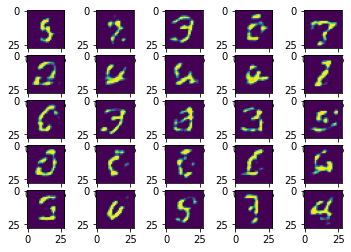

Step 7: [D] Loss:-2.261506667886025, Acc:0.9315738514957265
Step 7: [A] Loss:-3.7575426580559492, Acc:0.9833400106837606
(0,0): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(0,1): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(0,2): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(0,3): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(0,4): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(1,0): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,1): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(1,2): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(1,3): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(1,4): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(2,0): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,1): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(2,2): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(2,3): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,4): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,0): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,1): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(3,2): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(3,3): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(3,4): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(4,0): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(4,1): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(4,2): [0. 0. 0. 0. 0

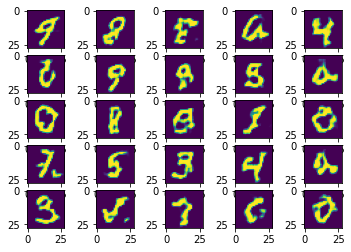

Step 8: [D] Loss:-2.279347364464377, Acc:0.9374749599358975
Step 8: [A] Loss:-3.7977559296493855, Acc:0.9838908920940171
(0,0): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(0,1): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(0,2): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(0,3): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,4): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(1,0): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(1,1): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(1,2): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,3): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(1,4): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(2,0): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(2,1): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(2,2): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,3): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(2,4): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(3,0): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(3,1): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(3,2): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(3,3): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(3,4): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(4,0): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(4,1): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(4,2): [0. 0. 0. 0. 0

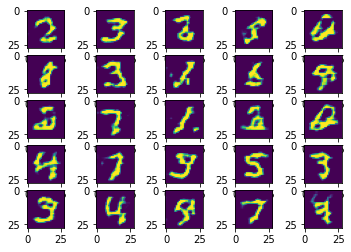

Step 9: [D] Loss:-2.2752089348868427, Acc:0.9428919604700855
Step 9: [A] Loss:-3.771778121463254, Acc:0.984107905982906
(0,0): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(0,1): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,2): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(0,3): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(0,4): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(1,0): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,1): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(1,2): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(1,3): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(1,4): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(2,0): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(2,1): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,2): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,3): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(2,4): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,0): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,1): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(3,2): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(3,3): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(3,4): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(4,0): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(4,1): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(4,2): [0. 1. 0. 0. 0.

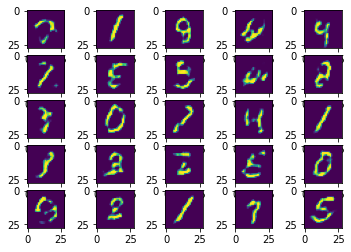

Step 10: [D] Loss:-2.3260600533750324, Acc:0.9459802350427351
Step 10: [A] Loss:-3.7730065416067076, Acc:0.9860276442307693
(0,0): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(0,1): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,2): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,3): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(0,4): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(1,0): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,1): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(1,2): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(1,3): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(1,4): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(2,0): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(2,1): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(2,2): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(2,3): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(2,4): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(3,0): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,1): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(3,2): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(3,3): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,4): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(4,0): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(4,1): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(4,2): [0. 0. 0. 0

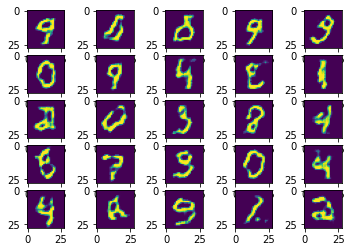

Step 11: [D] Loss:-2.3342405886222153, Acc:0.9492437900641025
Step 11: [A] Loss:-3.8068152732319303, Acc:0.9863448183760684
(0,0): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(0,1): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,2): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,3): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(0,4): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(1,0): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,1): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,2): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(1,3): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(1,4): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,0): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(2,1): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(2,2): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(2,3): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(2,4): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(3,0): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(3,1): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(3,2): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(3,3): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(3,4): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(4,0): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(4,1): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(4,2): [1. 0. 0. 0

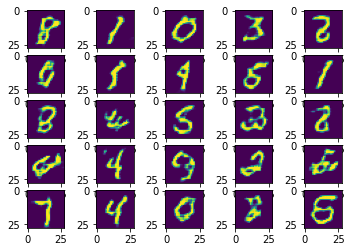

Step 12: [D] Loss:-2.351229706381121, Acc:0.9517311030982906
Step 12: [A] Loss:-3.8861762611275044, Acc:0.9871627938034188
(0,0): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,1): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(0,2): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,3): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(0,4): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(1,0): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(1,1): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(1,2): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,3): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(1,4): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(2,0): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(2,1): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(2,2): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,3): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(2,4): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(3,0): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(3,1): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(3,2): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(3,3): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(3,4): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(4,0): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(4,1): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(4,2): [0. 0. 0. 0.

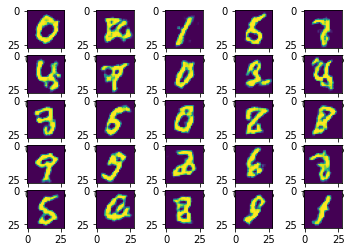

Step 13: [D] Loss:-2.3770158685680127, Acc:0.9497696314102564
Step 13: [A] Loss:-3.975711897907094, Acc:0.9857605502136753
(0,0): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(0,1): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(0,2): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,3): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(0,4): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(1,0): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(1,1): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(1,2): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(1,3): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(1,4): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(2,0): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(2,1): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(2,2): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(2,3): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,4): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(3,0): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(3,1): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(3,2): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(3,3): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,4): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(4,0): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(4,1): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(4,2): [0. 0. 0. 0.

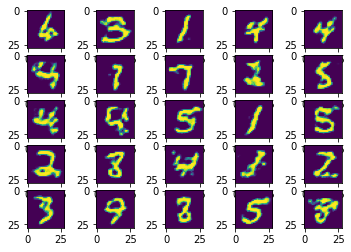

Step 14: [D] Loss:-2.347294590666763, Acc:0.9520649706196581
Step 14: [A] Loss:-3.997325012826512, Acc:0.9888989049145299
(0,0): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(0,1): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(0,2): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(0,3): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(0,4): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,0): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,1): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(1,2): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(1,3): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(1,4): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(2,0): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(2,1): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(2,2): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(2,3): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,4): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(3,0): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(3,1): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(3,2): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,3): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(3,4): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(4,0): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(4,1): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(4,2): [0. 0. 0. 0. 

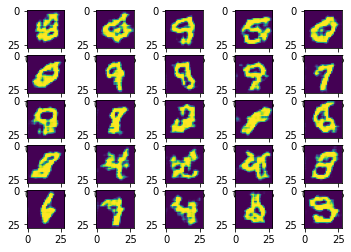

Step 15: [D] Loss:-2.3902657847119193, Acc:0.9550280448717948
Step 15: [A] Loss:-4.031220846705967, Acc:0.9892494658119658
(0,0): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(0,1): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(0,2): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(0,3): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(0,4): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(1,0): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,1): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(1,2): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,3): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(1,4): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,0): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(2,1): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(2,2): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(2,3): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(2,4): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(3,0): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(3,1): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,2): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(3,3): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,4): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(4,0): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(4,1): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(4,2): [0. 0. 0. 0.

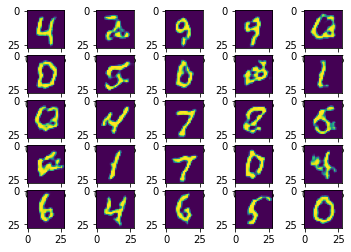

Step 16: [D] Loss:-2.3319525863879766, Acc:0.9579744257478633
Step 16: [A] Loss:-3.895888942429143, Acc:0.9878305288461539
(0,0): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(0,1): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(0,2): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,3): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,4): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,0): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(1,1): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,2): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(1,3): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(1,4): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(2,0): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,1): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,2): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(2,3): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(2,4): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,0): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(3,1): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,2): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,3): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(3,4): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(4,0): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(4,1): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(4,2): [0. 0. 0. 0.

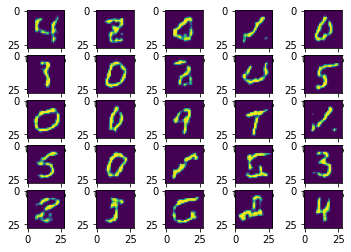

Step 17: [D] Loss:-2.332089464379172, Acc:0.9609041132478633
Step 17: [A] Loss:-3.964531027353727, Acc:0.9900841346153846
(0,0): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(0,1): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(0,2): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,3): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(0,4): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(1,0): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(1,1): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,2): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(1,3): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(1,4): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(2,0): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(2,1): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,2): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(2,3): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(2,4): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,0): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(3,1): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(3,2): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(3,3): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(3,4): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(4,0): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(4,1): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(4,2): [0. 0. 0. 1. 

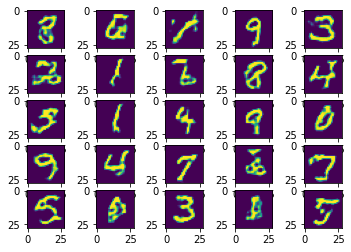

Step 18: [D] Loss:-2.375476544484114, Acc:0.9624232104700855
Step 18: [A] Loss:-3.978096706235511, Acc:0.9895499465811965
(0,0): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(0,1): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(0,2): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(0,3): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(0,4): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(1,0): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(1,1): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(1,2): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,3): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(1,4): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(2,0): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(2,1): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,2): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(2,3): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,4): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,0): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(3,1): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(3,2): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(3,3): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(3,4): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(4,0): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(4,1): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(4,2): [0. 1. 0. 0. 

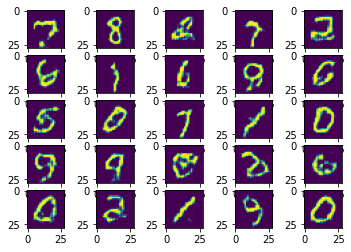

Step 19: [D] Loss:-2.3956646414903493, Acc:0.9626485710470085
Step 19: [A] Loss:-3.9811994270381765, Acc:0.9907184829059829
(0,0): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,1): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(0,2): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(0,3): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(0,4): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(1,0): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(1,1): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,2): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(1,3): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(1,4): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(2,0): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(2,1): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(2,2): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(2,3): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(2,4): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(3,0): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(3,1): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(3,2): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(3,3): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(3,4): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(4,0): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(4,1): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(4,2): [0. 0. 0. 0

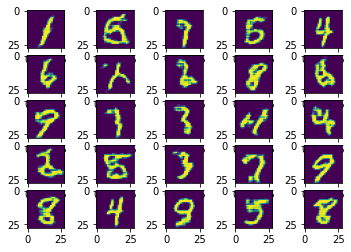

Step 20: [D] Loss:-2.39103073747749, Acc:0.9661458333333334
Step 20: [A] Loss:-4.0190857699793625, Acc:0.9928385416666666
(0,0): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,1): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(0,2): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(0,3): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(0,4): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(1,0): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(1,1): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(1,2): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(1,3): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,4): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(2,0): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(2,1): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,2): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(2,3): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(2,4): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,0): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(3,1): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(3,2): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(3,3): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,4): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(4,0): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(4,1): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(4,2): [0. 0. 0. 0. 

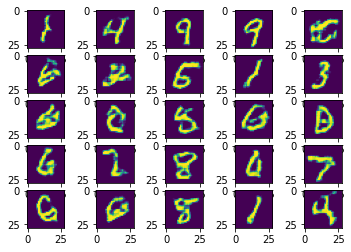

Step 21: [D] Loss:-2.392162348088036, Acc:0.9666967147435898
Step 21: [A] Loss:-4.095812168895689, Acc:0.9925714476495726
(0,0): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(0,1): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(0,2): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(0,3): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(0,4): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(1,0): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(1,1): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(1,2): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(1,3): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,4): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(2,0): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(2,1): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,2): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,3): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(2,4): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(3,0): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(3,1): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(3,2): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(3,3): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(3,4): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(4,0): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(4,1): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(4,2): [0. 0. 0. 0. 

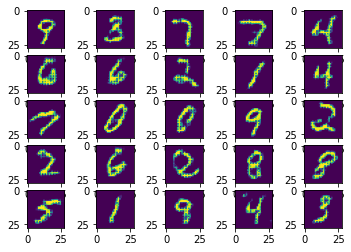

Step 22: [D] Loss:-2.3789610299799175, Acc:0.9681991185897436
Step 22: [A] Loss:-4.075897396629692, Acc:0.9925714476495726
(0,0): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(0,1): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(0,2): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(0,3): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(0,4): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,0): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(1,1): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(1,2): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(1,3): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(1,4): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(2,0): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,1): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,2): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(2,3): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,4): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(3,0): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(3,1): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(3,2): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(3,3): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(3,4): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(4,0): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(4,1): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(4,2): [0. 0. 0. 0.

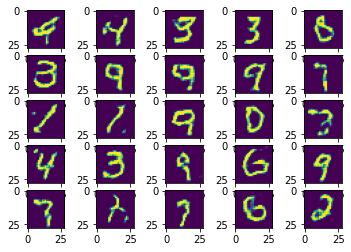

Step 23: [D] Loss:-2.398328937526442, Acc:0.9704777644230769
Step 23: [A] Loss:-4.091909306171613, Acc:0.994140625
(0,0): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,1): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(0,2): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(0,3): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(0,4): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(1,0): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,1): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(1,2): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(1,3): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(1,4): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(2,0): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(2,1): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(2,2): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(2,3): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,4): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(3,0): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(3,1): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,2): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(3,3): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(3,4): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(4,0): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(4,1): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(4,2): [0. 0. 0. 0. 0. 0. 0

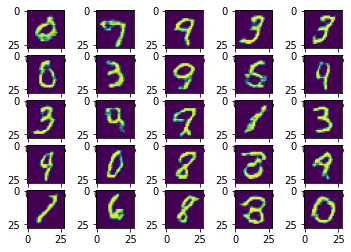

Step 24: [D] Loss:-2.368706398540073, Acc:0.9707949385683761
Step 24: [A] Loss:-4.074235275769845, Acc:0.9937733707264957
(0,0): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,1): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(0,2): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(0,3): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(0,4): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,0): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(1,1): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(1,2): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(1,3): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(1,4): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,0): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,1): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(2,2): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(2,3): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(2,4): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(3,0): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,1): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(3,2): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(3,3): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,4): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(4,0): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(4,1): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(4,2): [0. 0. 0. 0. 

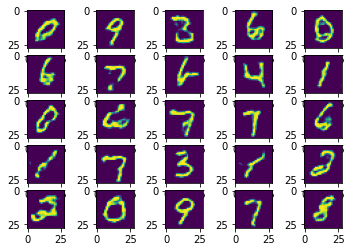

In [8]:
infogan.fit((X,Y), 128, 25)